In [1]:
import numpy as np # Para utilizar numpy
import pandas as pd # Para utilizar pandas
import matplotlib.pyplot as plt #Para las gráficas
import statsmodels.graphics.tsaplots as sgt #Gráficas de autocorrelación 
import statsmodels.tsa.stattools as sts #Para prueba de Dickey-Fuller
import seaborn as sns 
from statsmodels.tsa.arima.model import ARIMA #Para hacer el modelo ARIMA
from scipy.stats.distributions import chi2 #Nos sirve para la distribución Xi cuadrada 
from datetime import datetime #Para trabajar con fechas
import os #Para poner la dirección donde esta la base de datos.
sns.set()

<h1> Preprocesamiento de datos </h1>

Dado que los modelos Autorregresivos NO son muy buenos con datos que son estacionarios, entonces primero hacemos un preprocesamiento para después ver con la prueba de *Dickey-Fuller* si lo son o no.

In [5]:
os.chdir("C:\\Users\\81799\\OneDrive\\Documentos\\ESFM_CLASES\\Servicio Social ARTF\\Machine Learning\\curso-series-temporales-master\\5. Modelos AR autorregresivos\\Python") 
raw_csv_data = pd.read_csv("Index2018.csv") #Leer DataFrame Index2018
df_comp = raw_csv_data.copy() #Copia el DataFrame raw_csv_data con el nombre de df_comp
df_comp.date = pd.to_datetime(df_comp.date, dayfirst =True ) #Modifica las fechas
df_comp.set_index("date",inplace = True) # Ponemos las fechas como índices
df_comp=df_comp.asfreq("b") #Frecuencias a días laborales.
df_comp=df_comp.fillna(method="ffill")#Arregla problema d valores faltantes tomando su diferencia
df_comp["market_value"]=df_comp.ftse #Agregamos una nueva columna llamada market_value
del df_comp["spx"] #Eliminamos la columna spx del DataFrame de_comp
del df_comp["dax"] #Eliminamos la columna dax del DataFrame de_comp
del df_comp["ftse"] #Eliminamos la columna ftse del DataFrame de_comp
del df_comp["nikkei"] #Eliminamos la columna nikkei del DataFrame de_comp
size=int(len(df_comp)*0.8) #int (no. de filas*0.8)= int(6277*0.8)= int(5021.6)=5021
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

<h1> Prueba de Dickey-Fuller </h1>

In [6]:
sts.adfuller(df.market_value)

(-1.9041551418836855,
 0.33010893277028364,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54854.15304507557)

Dada la prueba de *Dickey-Fuller* tenemos que $p-valor>\alpha $, es decir $0.3301>0.05$ entonces tenemos que **Aceptamos** $H_0$ por lo cual los **datos son NO estacionarios**.

<h1> Usando Retornos </h1>

En finanzas se suele hacer una transformación para convertir los precios en **datos de retorno** porque con retorno se salvará el problema de tener datos NO estacionarios. Los retornos son un porcentaje de cambio entre los valores para períodos consecutivos, es decir un porcentaje de cambio entre los precios de dos períodos consecutivos:

$$y_t=\frac{x_t-x_{t-1}}{x_t}\cdot 100 \% $$

* Si el retorno ($y_t$) es **positivo**, esto significa que **hay un crecimiento** en los precios de un día para otro.
* Si el retorno ($y_t$) es **negativo**, esto significa que los precios **han disminuido** entre esos dos períodos.

In [14]:
df["Returns"]=df.market_value.pct_change(1).mul(100) # Guarda los retornos en la columna Returns
df

C:\Users\81799\AppData\Local\Temp\ipykernel_18364\2677877128.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Returns"]=df.market_value.pct_change(1).mul(100)


,market_value,Returns
date,,
1994-01-07,3445.98,NaN
1994-01-10,3440.58,-0.156704
1994-01-11,3413.77,-0.779229
1994-01-12,3372.02,-1.222988
1994-01-13,3360.01,-0.356166
...,...,...
2013-04-01,6411.74,0.000000
2013-04-02,6490.66,1.230867
2013-04-03,6420.28,-1.084327


Tenemos que el $2$do valor de la columna *Returns* se calcula de la siguiente manera:
$$\begin{array}{l} y_2&=\frac{x_2-x_1}{x_2}\cdot 100\% \\ y_2&=\frac{3440.58-3445.98}{3440.58}\cdot 100 \%  \\ y_2 &=-0.156704 \end{array}$$






In [16]:
df = df.iloc[1:] # Eliminamos la primera fila para no tener NA
df

,market_value,Returns
date,,
1994-01-11,3413.77,-0.779229
1994-01-12,3372.02,-1.222988
1994-01-13,3360.01,-0.356166
1994-01-14,3400.56,1.206842
1994-01-17,3407.83,0.213788
...,...,...
2013-04-01,6411.74,0.000000
2013-04-02,6490.66,1.230867
2013-04-03,6420.28,-1.084327


<h1> Aplicando Dickey-Fuller a la variable de retorno </h1>

In [17]:
sts.adfuller(df.Returns)

(-12.79033260390992,
 7.099523586682315e-24,
 32,
 4986,
 {'1%': -3.43166220814716,
  '5%': -2.862119853748156,
  '10%': -2.567078656914853},
 15690.778602127364)

En este caso, tenemos que $p-valor<\alpha $, ya que $7.01e^{-24}<0.05 $ entonces **Rechazamos** $H_0$ y conclui

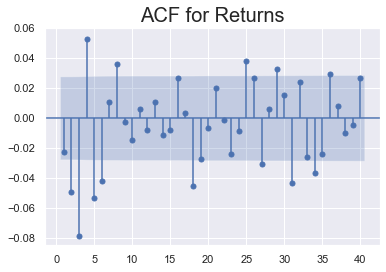

In [25]:
sgt.plot_acf(df.Returns, zero = False, lags = 40)
plt.title("ACF for Returns", size = 20)
plt.ylim(-0.085,0.06)
plt.show()

De la gráfica **ACF for Returns** observamos que:
* Hay  $13$ coeficientes de correlación  $\varphi _k$ significativos.

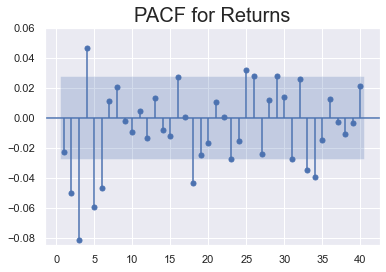

In [27]:
sgt.plot_pacf(df.Returns, zero = False, lags = 40, alpha =0.05, method = "ols")
plt.title("PACF for Returns", size = 20)
plt.ylim(-0.085,0.06)
plt.show()

Observamos que la gráfica  **PACF for Returns** es casi similiar a la gráfica **ACF for Returns**.

* La mayoría de los coeficientes $\varphi $ NO son significaativos.

<h1> AR(1) para Returns </h1>

In [28]:
model_ar_1 = ARIMA(df.Returns, order=(1,0,0)) 
results_ar_1 = model_ar_1.fit() #Guardamos en results para ver como se ajustan
#los datos (fit() es para ajustarlo)
results_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Returns   No. Observations:                 5019
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -7928.655
Date:                Mon, 23 May 2022   AIC                          15863.311
Time:                        17:39:51   BIC                          15882.874
Sample:                    01-11-1994   HQIC                         15870.166
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.145      0.252      -0.013       0.051
ar.L1         -0.0230      0.009     -2.699      0.007      -0.040      -0.006
sigma2         1.3793      0.014    100.071      0.000       1.352       1.406
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7866.61
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Dado lo anterior, tenemos que:

* El $p-valor$ del coeficiente $c$ es igual a $0.252$, lo cual indica que $p-valor _c >0.05$, por lo cual aceptamos $H_0$, así que **el coeficiente de c es significativamente igual a $0$**.

* El $p-valor$ del coeficiente $\Phi _1$ es igual a $0.007$, lo cual indica que $p-valor _{\Phi _1} <0.05$, por lo cual Rechazamos $H_0$, así que **el coeficiente de $\Phi _1$ es significativamente diferente de $0$**.

<h1>Comparando Modelos AR (p) Higher-Lag sobre Returns </h1>

* Si al comparar los modelos $AR(p)$ con $AR(p+l)$ obtenemos que los modelos son diferentes, escogeremos el de mayor complejidad, siempre y cuando el último coeficiente de $AR(p+l)$ sea significativamente distinto de $0$


La siguiente función *LLR_test(mod_1,mod_2,DF)* Nos sirve para obtener el $p-valor$ de la comparación de dos modelos.


In [ ]:
def LLR_test(mod_1,mod_2,DF=1): #DF son los grados de libertad
    L1=mod_1.llf # Me da Log Likelihood del mod_1 que de como entrada
    L2=mod_2.llf # Me da Log Likelihood del mod_2 que de como entrada
    LR=(2*(L2-L1)) # Estadístico de prueba
    p=chi2.sf(LR,DF).round(3) #P-valor
    return p

<h2> AR(1) y AR(2) </h2>

In [30]:
model_ar_2 = ARIMA(df.Returns, order =(2,0,0))
results_ar_2 = model_ar_2.fit()
print(results_ar_2.summary())
print("LRR test: "+str(LLR_test(results_ar_1, results_ar_2)))

                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                 5019
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -7922.353
Date:                Mon, 23 May 2022   AIC                          15852.707
Time:                        17:50:57   BIC                          15878.790
Sample:                    01-11-1994   HQIC                         15861.847
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.197      0.231      -0.012       0.050
ar.L1         -0.0242      0.009     -2.802      0.005      -0.041      -0.007
ar.L2         -0.0501      0.008     -6.375      0.0

En este caso: $AR(1)$ y $AR(2)$

* El $p-valor$ del coeficiente $\Phi _2$ es $0.000$, lo cual tendremos que $p-valor _{\Phi _2}<0.05$, por lo cual **Rechazamos** $H_0$ y concluimos que $\Phi _2$ es significativamente distinto de $0$.

* Al realizar la **Prueba de Razón Log-LikeLihood** respecto a $AR(1)$ y $AR(2)$ tenemos que $p-valor <\alpha $, es decir $0.0<0.05$, con esto **Rechazamos** $H_0$ y tenemos que los dos modelos son significativamente diferentes.


Dado los anteriores puntos, nos quedamos con el modelo $AR(2)$, ya que tiene mayor complejidad y $\Phi _2$ es significativamente distinto de $0$


<h2> AR(2) y AR(3) </h2>

In [31]:
model_ar_3 = ARIMA(df.Returns, order =(3,0,0))
results_ar_3 = model_ar_3.fit()
print(results_ar_3.summary())
print("LRR test: "+str(LLR_test(results_ar_2, results_ar_3)))

                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                 5019
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -7905.632
Date:                Mon, 23 May 2022   AIC                          15821.264
Time:                        18:03:00   BIC                          15853.869
Sample:                    01-11-1994   HQIC                         15832.689
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.275      0.202      -0.010       0.048
ar.L1         -0.0283      0.009     -3.203      0.001      -0.046      -0.011
ar.L2         -0.0521      0.008     -6.689      0.0

En este caso: $AR(2)$ y $AR(3)$

* El $p-valor$ del coeficiente $\Phi _3$ es $0.000$, lo cual tendremos que $p-valor _{\Phi _3}<0.05$, por lo cual **Rechazamos** $H_0$ y concluimos que $\Phi _3$ es significativamente distinto de $0$.

* Al realizar la **Prueba de Razón Log-LikeLihood** respecto a $AR(3)$ y $AR(2)$ tenemos que $p-valor <\alpha $, es decir $0.0<0.05$, con esto **Rechazamos** $H_0$ y tenemos que los dos modelos son significativamente diferentes.


Dado los anteriores puntos, nos quedamos con el modelo $AR(3)$, ya que tiene mayor complejidad y $\Phi _3$ es significativamente distinto de $0$


<h2> AR(3) y AR(4) </h2>

In [32]:
model_ar_4 = ARIMA(df.Returns, order =(4,0,0))
results_ar_4 = model_ar_4.fit()
print(results_ar_4.summary())
print("LRR test: "+str(LLR_test(results_ar_3, results_ar_4)))

                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                 5019
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -7900.213
Date:                Mon, 23 May 2022   AIC                          15812.427
Time:                        18:09:34   BIC                          15851.553
Sample:                    01-11-1994   HQIC                         15826.137
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.016      1.212      0.226      -0.012       0.049
ar.L1         -0.0246      0.009     -2.773      0.006      -0.042      -0.007
ar.L2         -0.0497      0.008     -6.335      0.0

En este caso: $AR(3)$ y $AR(4)$

* El $p-valor$ del coeficiente $\Phi _4$ es $0.000$, lo cual tendremos que $p-valor _{\Phi _4}<0.05$, por lo cual **Rechazamos** $H_0$ y concluimos que $\Phi _4$ es significativamente distinto de $0$.

* Al realizar la **Prueba de Razón Log-LikeLihood** respecto a $AR(3)$ y $AR(4)$ tenemos que $p-valor <\alpha $, es decir $0.001<0.05$, con esto **Rechazamos** $H_0$ y tenemos que los dos modelos son significativamente diferentes.


Dado los anteriores puntos, nos quedamos con el modelo $AR(4)$, ya que tiene mayor complejidad y $\Phi _4$ es significativamente distinto de $0$


<h2> AR(4) y AR(5) </h2>

In [33]:
model_ar_5 = ARIMA(df.Returns, order =(5,0,0))
results_ar_5 = model_ar_5.fit()
print(results_ar_5.summary())
print("LRR test: "+str(LLR_test(results_ar_4, results_ar_5)))

                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                 5019
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -7891.277
Date:                Mon, 23 May 2022   AIC                          15796.553
Time:                        18:12:59   BIC                          15842.200
Sample:                    01-11-1994   HQIC                         15812.549
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.277      0.202      -0.010       0.048
ar.L1         -0.0218      0.009     -2.400      0.016      -0.040      -0.004
ar.L2         -0.0545      0.008     -6.832      0.0

En este caso: $AR(4)$ y $AR(5)$

* El $p-valor$ del coeficiente $\Phi _5$ es $0.000$, lo cual tendremos que $p-valor _{\Phi _5}<0.05$, por lo cual **Rechazamos** $H_0$ y concluimos que $\Phi _5$ es significativamente distinto de $0$.

* Al realizar la **Prueba de Razón Log-LikeLihood** respecto a $AR(4)$ y $AR(5)$ tenemos que $p-valor <\alpha $, es decir $0.0<0.05$, con esto **Rechazamos** $H_0$ y tenemos que los dos modelos son significativamente diferentes.


Dado los anteriores puntos, nos quedamos con el modelo $AR(5)$, ya que tiene mayor complejidad y $\Phi _5$ es significativamente distinto de $0$


<h2> AR(5) y AR(6) </h2>

In [34]:
model_ar_6 = ARIMA(df.Returns, order =(6,0,0))
results_ar_6 = model_ar_6.fit()
print(results_ar_6.summary())
print("LRR test: "+str(LLR_test(results_ar_5, results_ar_6)))

                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                 5019
Model:                 ARIMA(6, 0, 0)   Log Likelihood               -7885.842
Date:                Mon, 23 May 2022   AIC                          15787.684
Time:                        18:15:30   BIC                          15839.852
Sample:                    01-11-1994   HQIC                         15805.965
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.014      1.327      0.185      -0.009       0.047
ar.L1         -0.0246      0.009     -2.643      0.008      -0.043      -0.006
ar.L2         -0.0524      0.008     -6.511      0.0

En este caso: $AR(5)$ y $AR(6)$

* El $p-valor$ del coeficiente $\Phi _6$ es $0.000$, lo cual tendremos que $p-valor _{\Phi _6}<0.05$, por lo cual **Rechazamos** $H_0$ y concluimos que $\Phi _6$ es significativamente distinto de $0$.

* Al realizar la **Prueba de Razón Log-LikeLihood** respecto a $AR(5)$ y $AR(6)$ tenemos que $p-valor <\alpha $, es decir $0.001<0.05$, con esto **Rechazamos** $H_0$ y tenemos que los dos modelos son significativamente diferentes.


Dado los anteriores puntos, nos quedamos con el modelo $AR(6)$, ya que tiene mayor complejidad y $\Phi _6$ es significativamente distinto de $0$


<h2> AR(6) y AR(7) </h2>

In [35]:
model_ar_7 = ARIMA(df.Returns, order =(7,0,0))
results_ar_7 = model_ar_7.fit()
print(results_ar_7.summary())
print("LRR test: "+str(LLR_test(results_ar_6, results_ar_7)))

                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                 5019
Model:                 ARIMA(7, 0, 0)   Log Likelihood               -7885.542
Date:                Mon, 23 May 2022   AIC                          15789.083
Time:                        18:18:03   BIC                          15847.772
Sample:                    01-11-1994   HQIC                         15809.649
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.015      1.307      0.191      -0.009       0.047
ar.L1         -0.0240      0.009     -2.582      0.010      -0.042      -0.006
ar.L2         -0.0517      0.008     -6.380      0.0

En este caso: $AR(6)$ y $AR(7)$

* El $p-valor$ del coeficiente $\Phi _7$ es $0.226$, lo cual tendremos que $p-valor _{\Phi _7}>0.05$, por lo cual **Aceptamos** $H_0$ y concluimos que $\Phi _7$ es significativamente igual a $0$.

* Al realizar la **Prueba de Razón Log-LikeLihood** respecto a $AR(6)$ y $AR(7)$ tenemos que $p-valor >\alpha $, es decir $0.438>0.05$, con esto **Aceptamos** $H_0$ y tenemos que los dos modelos son significaticativamente iguales.


Dado los anteriores puntos, nos quedamos con el modelo $AR(6)$, ya que son modelos significativamente iguales, por ende escogemos el más simple, además $\Phi _7$ es significativamente igual a $0$

<h2> AR(6) y AR(8) </h2>

In [36]:
model_ar_8 = ARIMA(df.Returns, order =(8,0,0))
results_ar_8 = model_ar_8.fit()
print(results_ar_8.summary())
print("LRR test: "+str(LLR_test(results_ar_6, results_ar_8, DF=2)))

                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                 5019
Model:                 ARIMA(8, 0, 0)   Log Likelihood               -7884.495
Date:                Mon, 23 May 2022   AIC                          15788.990
Time:                        18:24:43   BIC                          15854.200
Sample:                    01-11-1994   HQIC                         15811.841
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.015      1.270      0.204      -0.010       0.048
ar.L1         -0.0243      0.009     -2.587      0.010      -0.043      -0.006
ar.L2         -0.0508      0.008     -6.255      0.0

En este caso: $AR(6)$ y $AR(8)$

* El $p-valor$ del coeficiente $\Phi _8$ es $0.031$, lo cual tendremos que $p-valor _{\Phi _7}<0.05$, por lo cual **Rechazamos** $H_0$ y concluimos que $\Phi _8$ es significativamente diferente de $0$.

* Al realizar la **Prueba de Razón Log-LikeLihood** respecto de $AR(6)$ y $AR(8)$ tenemos que $p-valor >\alpha $, es decir $0.26>0.05$, con esto **Aceptamos** $H_0$ y tenemos que los dos modelos son significaticativamente iguales.


Dado los anteriores puntos, nos quedamos con el modelo $AR(6)$, ya que son modelos significativamente iguales, por ende escogemos el más simple.

<h1> Análisis de los Residuos con respecto a los Returns del modelo AR(6) </h1>

In [37]:
df["Residuos_price"] = results_ar_6.resid # Extrae los residuos del modelo

C:\Users\81799\AppData\Local\Temp\ipykernel_18364\3811982464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Residuos_price"] = results_ar_6.resid # Extrae los residuos del modelo


In [38]:
sts.adfuller(df.Residuos_price)

(-70.77915840668122,
 0.0,
 0,
 5018,
 {'1%': -3.4316538358533277,
  '5%': -2.8621161549128313,
  '10%': -2.567076687880585},
 15686.691414583955)

Con un $p-valor<\alpha $, es decir, $0<0.05$ tenemos que **Rechazamos $H_0$**, por lo cual concluimos que **los residuos del modelo son Estacionarios**

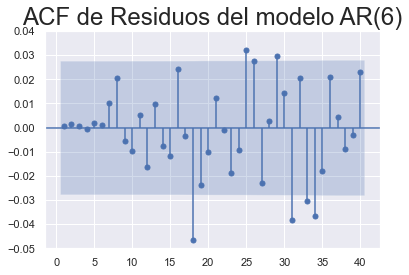

In [44]:
sgt.plot_acf(df.Residuos_price, zero = False , lags =40)
plt.title("ACF de Residuos del modelo AR(6)", size = 24)
plt.ylim(-.05,.04)
plt.show()

Observamos que la mayoria de los retraso $\varphi $ caen dentro de la zona azul, por lo cual son significativmente iguales a $0$, es decir, que no hay autocorrelación. Sin embargo hay puntos que salen del área azul, esto sugiere que aunque el modelo $AR(6)$ es un buen modelo para predecir, lo que nos sugiere es que puede haber un mejor predictor.

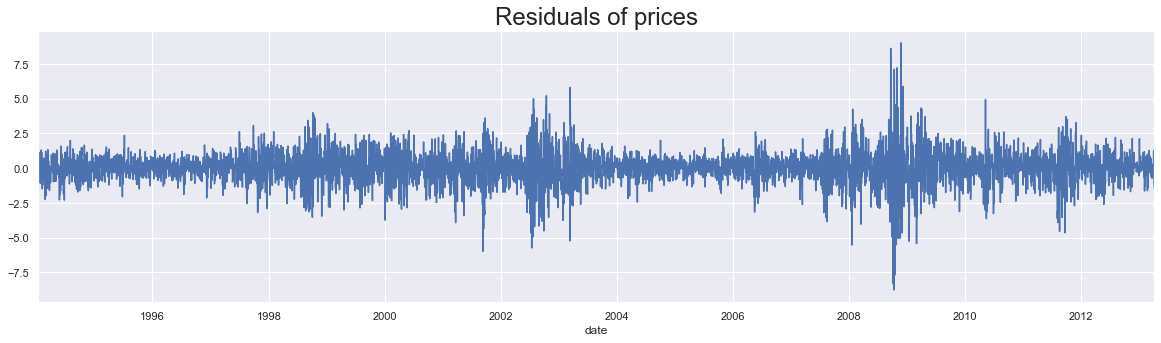

In [45]:
df.Residuos_price[1:].plot(figsize=(20,5))
plt.title("Residuals of prices", size =24)
plt.show()

Observamos que la gráfica de los residuos se parecen a los de un **ruido blanco**, es decir, que no hay ningún patrón.

<h1> CONCLUSIÓN </h1>


Si se mira el modelo $AR(6)$ se observa que todos los coeficientes son significativos distintos de $0$, con excepción del coeficiente de $c$ que es significativamente igual a $0$, aún con esto, observamos que los modelos $AR(p)$ se ajustan muy bien cuando tenemos datos estacionarios. 